## Probe trajectories expected in histology
This image shows, for each mouse that has probe insertions and trajectories in DataJoint, the location, probe name, angle and session date for each penetration.

__Note a few things__
* the view is seen from the top, i.e. same as coordinate system during stereotactic  insertion
* 0, 0 is Bregma
* only those penetrations that are in DJ are plotted. if any are missing, please do the following:
    1. check that all sessions for that mouse have probe trajectories, with *both* 'Planned' and 'Micro-manipulator' provenance, logged in Alyx
    2. wait 24 hours for these entries to propagate to DJ. if they don't appear in DJ, ask Shan.
    3. re-run the notebook (or ask me nicely to do it for you) if you have added trajectories/penetrations
* these are *not* the brains that have gone through histology, just the ones that are listed in Alyx. Check with Steve's histology dashboard to see if all of your brains have been imaged.

Anne Urai, CSHL, 2020

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

import datajoint as dj
from ibl_pipeline import subject, histology, ephys, acquisition
#ephys = dj.create_virtual_module('ephys', 'ibl_ephys')
figpath = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')
print(figpath)

/Users/urai/Data/Figures_IBL


In [74]:
# lab_name = "churchlandlab"
traj = acquisition.Session * ephys.ProbeInsertion * (histology.ProbeTrajectory & 'insertion_data_source = "Micro-manipulator"') \
        * subject.Subject * (subject.SubjectLab & 'lab_name = "churchlandlab"')
traj = traj.proj('subject_nickname', 'x', 'y', 'theta', 'phi', 'theta', 'depth', 'lab_name', 'session_number',
                 'probe_label', session_date='DATE(session_start_time)')
traj = traj.fetch(format='frame').reset_index()

In [75]:
traj['probe_phi'] = traj['phi'].map({180:'180deg', 0:'0deg'})
traj['theta_name'] = traj['theta'].map({10:'10deg', 15:'15deg', 17:'17deg'})
traj['depth'] = round(traj.depth, -3) # round to nearest 1000
traj['probe_name'] = traj.probe_label + ', ' + traj.theta_name + ', ' + 'D=' + traj.depth.astype(str)
# traj['probe_name'] = traj.probe_label + ', ' + traj.theta_name
traj = traj.sort_values(by=['subject_nickname'])
traj['session_date'] = traj['session_date'].astype(str) + ' / 00' + traj['session_number'].astype(str)
traj['source'] = 'datajoint'
# traj_dj = traj.copy()
# print(traj.probe_name.unique())

done


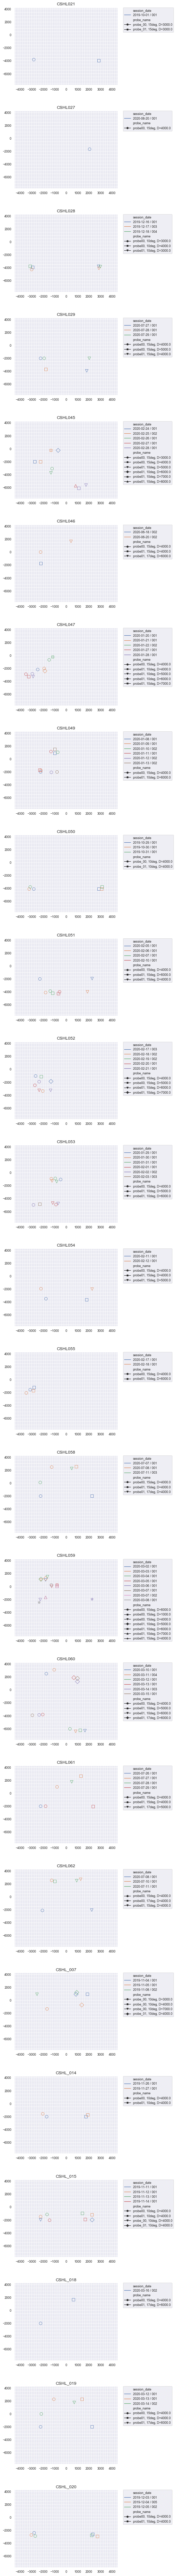

In [76]:
sns.set(style="darkgrid", context="paper")
markers = ['o', 's', 'v',  'D', 'X', '^', '*', 'h', 'H',  'd', 'p', 'P']
g, axes = plt.subplots(traj.subject_nickname.nunique(), 1, 
                       figsize=(7, 4*traj.subject_nickname.nunique()))

for sp, ax in zip(traj.subject_nickname.unique(), axes.flatten()):
    
    df = traj[traj.subject_nickname==sp]
    sns.lineplot(data=df, x='x', y='y', hue="session_date", style="probe_name",
                 hue_order=sorted(df.session_date.unique()), 
                 style_order=sorted(df.probe_name.dropna().unique()), 
                 markers=markers, linewidth=0, markersize=8, mfc='none', mec='auto', 
                 ax=ax, legend='full', dashes=False)
    
    # can't get facecolor=none to work with relplot...
        #     g = sns.relplot(data=df, x='x', y='y', 
        #                 hue="session_date", palette='Set1', 
        #                 style="probe_name", markers=markers,
        #                 size='depth', size_norm=(3000, 6000),
        #                 facecolors='none',
        #                 legend='full',
        #                 height=3, aspect=1.25)

    ax.set_title(sp, fontsize=12)
    ax.set(xlim=[-4500, 4500], ylim=[-7750, 4250], xlabel='', ylabel='')
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
# g.savefig(os.path.join(figpath, 'probe_trajectories_forhistology.pdf'))
print('done')

## same plot but with ONE

In [11]:
## REPEAT WITH ONE
from oneibl.one import ONE
one = ONE()
trajs = one.alyx.rest('trajectories', 'list', provenance='micro-manipulator')
traj = pd.DataFrame(list(trajs))

Param ALYX_LOGIN,  current value is [test_user]:anneu
Param ALYX_URL,  current value is [https://test.alyx.internationalbrainlab.org]:alyx.internationalbrainlab.org
Param CACHE_DIR,  current value is [/Users/anne/Downloads/FlatIron]:
Param FTP_DATA_SERVER,  current value is [ftp://ibl.flatironinstitute.org]:
Param FTP_DATA_SERVER_LOGIN,  current value is [iblftp]:
Param HTTP_DATA_SERVER,  current value is [http://ibl.flatironinstitute.org]:
Param HTTP_DATA_SERVER_LOGIN,  current value is [iblmember]:
Param GLOBUS_CLIENT_ID,  current value is [None]:
Enter the Alyx password for anneu(leave empty to keep current):········
Enter the FlatIron HTTP password for iblmember(leave empty to keep current): ········
Enter the FlatIron FTP password for iblftp(leave empty to keep current): ········
ONE Parameter file location: /Users/anne/.one_params


MissingSchema: Invalid URL 'alyx.internationalbrainlab.org/auth-token': No schema supplied. Perhaps you meant http://alyx.internationalbrainlab.org/auth-token?

In [ ]:
# get the subject info out of the 'session' column
for kix, k in enumerate(traj.session[0].keys()):
    tmp_var = []
    for id, c in traj.iterrows():
        if k in c['session'].keys():
            tmp = c['session'][k]
        else:
            tmp = np.nan
        tmp_var.append(tmp)
        # also add the date
    traj[k] = tmp_var
    
traj['theta_name'] = traj['theta'].map({10:'10deg', 15:'15deg', 17:'17deg'})
traj['probe_name'] = traj.probe_name + ', ' + traj.theta_name
traj['session_date'] = traj['start_time'].str[0:10]
traj = traj.sort_values(by=['subject'])
traj['source'] = 'one'
traj['subject_nickname'] = traj['subject']
traj_alyx = traj.copy()
print(traj.columns)

In [9]:
traj_dj

,subject_uuid,session_start_time,probe_idx,insertion_data_source,probe_label,x,y,phi,theta,depth,subject_nickname,lab_name,session_date,probe_phi,angle,theta_name,probe_name,source
216,70672c7d-cc8b-4555-be08-0795b25935b1,2019-10-01 15:03:32,1,Micro-manipulator,probe_01,2835.0,-4000.0,0.0,15.0,3000.0,CSHL021,churchlandlab,2019-10-01,0deg,15.0,15deg,"probe_01, 15deg",datajoint
215,70672c7d-cc8b-4555-be08-0795b25935b1,2019-10-01 15:03:32,0,Micro-manipulator,probe_00,-2834.2,-3800.0,180.0,15.0,3000.0,CSHL021,churchlandlab,2019-10-01,180deg,15.0,15deg,"probe_00, 15deg",datajoint
20,09da30a5-53cd-4f69-85d9-1accb3fa523b,2019-12-18 11:19:52,1,Micro-manipulator,probe01,2971.2,-3809.5,0.0,10.0,3499.9,CSHL028,churchlandlab,2019-12-18,0deg,10.0,10deg,"probe01, 10deg",datajoint
19,09da30a5-53cd-4f69-85d9-1accb3fa523b,2019-12-18 11:19:52,0,Micro-manipulator,probe00,-3136.2,-3797.0,180.0,10.0,3500.4,CSHL028,churchlandlab,2019-12-18,180deg,10.0,10deg,"probe00, 10deg",datajoint
18,09da30a5-53cd-4f69-85d9-1accb3fa523b,2019-12-17 16:36:07,1,Micro-manipulator,probe01,2835.9,-4103.6,0.0,10.0,3499.7,CSHL028,churchlandlab,2019-12-17,0deg,10.0,10deg,"probe01, 10deg",datajoint
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,c00e0ffb-b8c6-4953-b9e7-975a3f4fd989,2019-12-11 15:24:31,0,Micro-manipulator,probe00,-2246.0,-2000.0,180.0,15.0,4000.0,ibl_witten_14,wittenlab,2019-12-11,180deg,15.0,15deg,"probe00, 15deg",datajoint
354,c00e0ffb-b8c6-4953-b9e7-975a3f4fd989,2019-12-04 18:33:48,0,Micro-manipulator,probe00,981.3,-3491.7,0.0,17.0,5390.9,ibl_witten_14,wittenlab,2019-12-04,0deg,17.0,17deg,"probe00, 17deg",datajoint
355,c00e0ffb-b8c6-4953-b9e7-975a3f4fd989,2019-12-04 18:33:48,1,Micro-manipulator,probe01,-1870.0,-2473.8,180.0,15.0,4000.0,ibl_witten_14,wittenlab,2019-12-04,180deg,15.0,15deg,"probe01, 15deg",datajoint
356,c00e0ffb-b8c6-4953-b9e7-975a3f4fd989,2019-12-05 18:40:56,0,Micro-manipulator,raw_ephysData_g0,684.7,-3272.1,0.0,17.0,5749.0,ibl_witten_14,wittenlab,2019-12-05,0deg,17.0,17deg,"raw_ephysData_g0, 17deg",datajoint


In [13]:
## merge the two
# TAKE ONLY ANIMALS THAT ARE PRESENT IN BOTH SOURCES
# dontuse_sjs = (list(set(traj_alyx.subject_nickname) - set(traj_dj.subject_nickname))) 
# print(dontuse_sjs)
# traj_dj = traj_dj[~traj_dj['subject_nickname'].isin(dontuse_sjs)]
# traj = pd.concat([traj_dj, traj_alyx], sort=False)

traj = traj_dj
# loop over subjects and sources
traj['sp'] = traj.subject_nickname + ', ' + traj.source
traj = traj.sort_values(by=['sp'])

## plot datajoint and ONE results side by side

In [19]:
markers = ['o', 's', 'v', 'P', '*', 'h', '^', 'H', 'D', 'd', 'X','p']
g, axes = plt.subplots(traj.subject_nickname.nunique(), 1, 
                       figsize=(5,4*traj.subject_nickname.nunique()))

for sp, ax in zip(traj.sp.unique(), axes.flatten()):
    
    df = traj[traj.sp==sp]
    sns.lineplot(data=df, x='x', y='y', hue="session_date", style="probe_name", 
                 hue_order=sorted(df.session_date.unique()), 
                 style_order=sorted(df.probe_name.dropna().unique()), 
                 markers=True, linewidth=0, markersize=8, mfc='none', mec='auto',palette='Set1', 
                 ax=ax, legend='full', dashes=False)

    ax.set_title(sp, fontsize=12)
    ax.set(xlim=[-4500, 4500], ylim=[-7750, 4250], xlabel='', ylabel='')
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.tight_layout()
#g.savefig(os.path.join(figpath, 'probe_trajectories_forhistology.pdf'))
print('done')

done
Error in callback <function flush_figures at 0x1a1e6f7170> (for post_execute):


KeyboardInterrupt: 